![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)

# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Gabriel Iturra, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

_Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir._

---

## Reglas

- Fecha de entrega: 19/12/2023
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia.
- Pueden usar cualquier material del curso que estimen conveniente.

---

### Integrantes:
- Nicolás Acevedo
- Fabiola Pizarro

### **Link de repositorio de GitHub:** `https://github.com/nicoacevedor/MDS7202`


# Presentación del Problema


### Introducción

Giturra, un emprendedor bancario, estableció su propio banco con la ambición de obtener ganancias considerables. Sin embargo, a medida que su institución financiera crecía, Giturra se enfrentó a un aumento significativo en la cantidad de préstamos impagos, lo que suponía una amenaza para la sostenibilidad y la reputación de su negocio. Para abordar este desafío, reconoció la necesidad imperante de mitigar los riesgos asociados a los préstamos y mejorar la calidad de las concesiones crediticias, empleando la ciencia de datos y el análisis de riesgo crediticio.

El desafío planteado consiste en el desarrollo de un sistema predictivo de riesgo crediticio específicamente diseñado para el banco de Giturra. El objetivo principal es anticipar la probabilidad de incumplimiento en los pagos por parte de los clientes solicitantes de préstamos. Este enfoque tiene como propósito proporcionar a la entidad bancaria una herramienta efectiva para evaluar el nivel de riesgo asociado a cada cliente y a cada préstamo en particular. Al estimar la probabilidad de incumplimiento para cada cliente, la institución estará en condiciones de tomar decisiones más informadas respecto a la aprobación o rechazo de préstamos, y ajustar las condiciones crediticias para mitigar posibles riesgos.

Es crucial que el modelo resulte comprensible para el equipo de Giturra, es decir, que sea fácil de interpretar y explicar. Esta característica facilitará la identificación de las variables más influyentes en la predicción de riesgo, permitiendo al equipo bancario entender cómo se fundamentan las decisiones crediticias en función de dichas variables.

Los datos proporcionados para este problema incluyen información detallada sobre los clientes que solicitan préstamos al banco. Esto abarca datos personales como edad, ocupación, así como información financiera relevante, incluyendo ingresos mensuales y anuales. Además, se cuenta con datos sobre el comportamiento crediticio previo de los clientes, como historial de pagos, deuda pendiente, posibles retrasos en el pago, entre otros aspectos.

Dentro de este contexto, es crucial identificar los falsos negativos, es decir, personas que se consideran pagadoras pero que no cumplirán con el pago del préstamo. Esta identificación correcta es fundamental para evitar riesgos financieros, ya que Giturra enfrenta un aumento en la cantidad de préstamos impagos. En consecuencia, se ha decidido evaluar el rendimiento de los modelos utilizando la métrica de `recall`, enfocándose específicamente en la detección de personas que no cumplen con sus pagos. Esta métrica permite verificar el funcionamiento del modelo al determinar el porcentaje del total de personas que no pagarán que efectivamente fueron identificadas como incumplidoras, abordando así el desafío del desequilibrio de clases en los datos.

**falta final de la intro**

### Importación de librerías a utilizar

In [1]:
from lightgbm import LGBMClassifier
import optuna
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Configuraciones generales del proyecto

In [2]:
random_state = 42
train_size = 0.7
val_size = 0.2

### Análisis exploratiorio de los datos

In [3]:
df_raw = pd.read_parquet("dataset.pq")
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12500 non-null  object 
 1   age                       12500 non-null  float64
 2   occupation                12500 non-null  object 
 3   annual_income             12500 non-null  float64
 4   monthly_inhand_salary     10584 non-null  float64
 5   num_bank_accounts         12500 non-null  int64  
 6   num_credit_card           12500 non-null  int64  
 7   interest_rate             12500 non-null  int64  
 8   num_of_loan               12500 non-null  float64
 9   delay_from_due_date       12500 non-null  int64  
 10  num_of_delayed_payment    11660 non-null  float64
 11  changed_credit_limit      12246 non-null  float64
 12  num_credit_inquiries      12243 non-null  float64
 13  outstanding_debt          12500 non-null  float64
 14  credit

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [4]:
df_raw['credit_score'].value_counts(normalize=True)

credit_score
0    0.71184
1    0.28816
Name: proportion, dtype: float64

### 3. Preparación de Datos

Antes de proceder con el desarrollo del modelo, es crucial abordar y resolver ciertos aspectos identificados durante el Análisis Exploratorio de Datos (EDA). Estos puntos incluyen:

- **Age:** se identificó que la columna de edad presenta valores anómalos, con un mínimo de -500 y un máximo de 8.678 años. Además, aproximadamente el 0.8% de los datos corresponden a personas con una edad menor que cero, lo cual carece de sentido lógico. Con el fin de mantener la coherencia, se ha establecido un rango de edad aceptable entre 14 y 100 años. En muchos países, la edad mínima para acceder al sistema financiero es de 14 años, mientras que los clientes mayores a 100 años generalmente tienen una influencia limitada en las operaciones bancarias.

- **Interest_rate:** se observó un valor máximo de 5.789 en esta columna, lo cual es inverosímil, dado que las tasas de interés en el sistema bancario suelen estar reguladas y no deberían superar el 50%. Se tomará una medida objetiva eliminando los valores que excedan el 100%, ya que esta columna representa porcentajes.

- **num_of_loan, num_bank_accounts, delay_from_due_date, num_of_delayed_payment:** estas columnas contienen valores negativos, lo cual resulta incoherente ya que representan cantidades. Por lo tanto, se ha decidido eliminar las filas que presenten valores negativos en estas columnas para mantener la integridad de los datos.

- **customer_id:** considerando que esta variable no aporta información relevante para el entrenamiento del modelo, dado que su propósito es únicamente identificar a las personas en el dataset, se ha determinado eliminarla. El enfoque del modelo se centra en otros atributos más significativos para el análisis y no en la identificación de individuos en el conjunto de datos.

A continuaciónse procede a abordar y resolver estos puntos identificados en el dataset.

In [5]:
# Limpieza de los datos
df = df_raw.copy()
# Edad entre 14 y 100
df = df[(df['age'] >= 14) & (df['age'] <= 100)]
# Tasa de interés máximo de 100%
df = df[df['interest_rate'] <= 100]
# Eliminar valores negativos
df = df[df['num_of_loan'] >= 0]
df = df[df['num_bank_accounts'] >= 0]
df = df[df['delay_from_due_date'] >= 0]
df = df[df['num_of_delayed_payment'] >= 0]
# Eliminación de la columna "customer_id"
df = df.drop(columns=['customer_id'])

In [6]:
df.shape

(10528, 21)

Tras la limpieza de los datos, el dataset resultante consta de 10.528 filas y 21 columnas. Esta cifra representa una reducción del 12%, aproximadamente, desde el conjunto inicial de 12.500 filas. A pesar de esta disminución, aún se conserva una cantidad considerable de datos para llevar a cabo el análisis sin impactar significativamente el volumen de la muestra.

#### 3.1 Preprocesamiento con `ColumnTransformer`

Durante el Análisis Exploratorio de Datos (EDA), se identificaron ciertas columnas en las que se ha interpretado erróneamente su tipo de datos correspondiente. Estas son:

- **Age:** actualmente, esta columna está catalogada como `float64`. Se ha tomado la decisión de cambiar su tipo a `int`, dado que la edad de una persona suele representarse como un número entero, careciendo de sentido asignar valores decimales a la edad.
  
- **Num_of_loan:** en la actualidad, esta columna se encuentra clasificada como `float64`. Se ha optado por cambiar su tipo a `int`, ya que la cantidad de préstamos tomados por una persona debe ser un número entero. Los préstamos no pueden tomarse en fracciones.
  
- **Delay_from_due_date:** esta columna ha sido clasificada como `int64`. Se ha decidido cambiar su tipo a `float64`, ya que representa la cantidad promedio de días de retraso en los pagos, por lo que podría contener decimales.

Estos ajustes en la tipificación de datos son fundamentales, ya que garantizan una representación más precisa de la información, lo que a su vez facilita un análisis más certero y la aplicación eficaz de modelos predictivos. 

In [7]:
# Se cambian los tipos de datos
df['age'] = df['age'].astype('int64')
df['num_of_loan'] = df['num_of_loan'].astype('int64')
df['delay_from_due_date'] = df['delay_from_due_date'].astype('float64')

A continuación, se crea un `ColumnTransformer` para llevar a cabo el preprocesamiento de datos categóricos y ordinales, además de escalar los datos numéricos. Los pasos específicos son los siguientes:

- **Datos categóricos:** se identifican las columnas `occupation`, `payment_of_min_amount`, y `payment_behaviour` como variables categóricas. Estas columnas se someten a un proceso de preprocesamiento utilizando `OneHotEncoder`. Esta técnica permite transformar estas características en variables numéricas binarias, asegurando una representación adecuada para su posterior uso en modelos predictivos.

- **Datos numéricos:** las columnas que no se consideran categóricas se clasifican como numéricas. Para escalar estas características, se opta por aplicar `MinMaxScaler`. Esta estrategia ajusta los datos dentro de un rango entre 0 y 1, preservando así las relaciones proporcionales entre los diferentes valores numéricos.

In [8]:
# Función para generar el scaler en todas las partes que se necesite
def generate_scaler(numeric_cols, categorical_cols):
    scaler = ColumnTransformer([
        ("NumericScaler", MinMaxScaler(), numeric_cols),
        ("CategoricalEncoder", OneHotEncoder(sparse_output=False), categorical_cols)
    ], remainder="passthrough")
    scaler.set_output(transform='pandas')
    return scaler

In [9]:
# Se divide el DataFrame en características (X) y variable objetivo (y)
X = df.drop(["credit_score"], axis=1)
y = df["credit_score"]

# Definición de variables categóricas y numéricaas
categorical_cols = ['occupation', 'payment_of_min_amount', 'payment_behaviour']
numeric_cols = list(set(X.columns) - (set(categorical_cols)))

# ColumnTransformer
scaler = generate_scaler(numeric_cols, categorical_cols)

# Se prueban las transformaciones
X_preprocessed = scaler.fit_transform(X)

#### 3.2 Holdout 

A continuación, se generan los conjuntos de entrenamiento, validación y prueba. 

In [10]:
# Función para separar los datos en todas las partes que se necesite
def split_data(X, y, train_size, val_size, random_state=random_state):
    X_train, X_med, y_train, y_med = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_med, y_med, train_size=val_size / (1 - train_size), random_state=random_state
    )
    return (
        X_train,
        X_val,
        X_test,
        y_train,
        y_val,
        y_test
    )

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=train_size, val_size=val_size)

#### 3.3 Datos nulos

Se lleva a cabo una revisión del dataset para identificar las columnas que contienen valores nulos, indicando el porcentaje de datos ausentes específicamente en estas columnas.

In [11]:
porcentajes_nulos = (df.isnull().sum() / len(df))
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0].sort_values(ascending=False)
print("Columnas con valores nulos [%]")
print("------------------------------")
porcentajes_nulos

Columnas con valores nulos [%]
------------------------------


monthly_inhand_salary      0.152451
credit_history_age         0.088526
amount_invested_monthly    0.046922
monthly_balance            0.028210
num_credit_inquiries       0.020802
changed_credit_limit       0.020327
dtype: float64

Se identifica que la columna `monthly_inhand_salary` muestra la mayor cantidad de valores nulos, siendo aproximadamente alrededor del 15%. No obstante, otras columnas también presentan valores nulos, con porcentajes variados que oscilan entre el 8% y el 2% aproximadamente. Se sospecha que el salario puede estar relacionado con el riesgo crediticio, lo que implica que la eliminación de muestras con valores NaN en esta variable podría generar un sesgo considerable debido a la alta proporción de valores ausentes. Esta situación se replica en otras columnas, como `credit_history_age`.

Por consiguiente, se ha tomado la decisión de conservar y abordar los datos nulos mediante técnicas de imputación. Esta estrategia permitirá mantener la integridad del conjunto de datos, preservando la información valiosa relacionada con el riesgo crediticio que podrían aportar estas variables, a pesar de la ausencia de algunos datos.    

### 4 Baseline

In [12]:
# Imputador
imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant'))
])

# Función para crear la pipeline en todas las partes que se necesite
def create_pipeline(scaler, model):
    pipeline = Pipeline([
        ("scaler", scaler),
        ('imputer', imputer),
        ("model", model)
    ])
    return pipeline

# Modelos
all_models = {
    "dummy": DummyClassifier(strategy="stratified", random_state=random_state),
    "logistic_reg": LogisticRegression(random_state=random_state),
    "k_neighbors": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(random_state=random_state),
    "svc": SVC(random_state=random_state),
    "random_forest": RandomForestClassifier(random_state=random_state),
    "lgbm": LGBMClassifier(random_state=random_state, verbose=-1),
    "xgb": XGBClassifier(random_state=random_state),
}

### Entrenamiento de los modelos

In [13]:
recall_by_model = {}

for name, model in all_models.items():
    print(name)
    pipeline = create_pipeline(scaler, model)
    display(pipeline.fit(X_train, y_train))
    y_pred = pipeline.predict(X_val)
    cr = classification_report(y_val, y_pred, output_dict=True)
    recall_by_model[name] = cr['1']['recall']
    print(f"Classification Report '{name}'")
    print(classification_report(y_val, y_pred), '\n')

dummy


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   '...
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Classification Report 'dummy'
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1510
           1       0.29      0.30      0.30       596

    accuracy                           0.60      2106
   macro avg       0.51      0.51      0.51      2106
weighted avg       0.60      0.60      0.60      2106
 

logistic_reg


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'monthly_balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LogisticRegression(random_state=42))])

Classification Report 'logistic_reg'
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1510
           1       0.63      0.35      0.45       596

    accuracy                           0.76      2106
   macro avg       0.71      0.63      0.65      2106
weighted avg       0.74      0.76      0.73      2106
 

k_neighbors


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'monthly_balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', KNeighborsClassifier())])

Classification Report 'k_neighbors'
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1510
           1       0.51      0.39      0.44       596

    accuracy                           0.72      2106
   macro avg       0.64      0.62      0.63      2106
weighted avg       0.70      0.72      0.71      2106
 

decision_tree


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   '...ly_balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

Classification Report 'decision_tree'
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1510
           1       0.47      0.52      0.49       596

    accuracy                           0.70      2106
   macro avg       0.64      0.64      0.64      2106
weighted avg       0.71      0.70      0.70      2106
 

svc


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   'monthly_balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', SVC(random_state=42))])

Classification Report 'svc'
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1510
           1       0.67      0.39      0.49       596

    accuracy                           0.77      2106
   macro avg       0.73      0.65      0.67      2106
weighted avg       0.76      0.77      0.75      2106
 

random_forest


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   '...ly_balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', RandomForestClassifier(random_state=42))])

Classification Report 'random_forest'
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1510
           1       0.68      0.53      0.59       596

    accuracy                           0.80      2106
   macro avg       0.75      0.72      0.73      2106
weighted avg       0.79      0.80      0.79      2106
 

lgbm


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   '...balance',
                                                   'total_emi_per_month',
                                                   'delay_from_due_date',
                                                   'num_of_loan', 'age',
                                                   'monthly_inhand_salary']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LGBMClassifier(random_state=42, verbose=-1))])

Classification Report 'lgbm'
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1510
           1       0.66      0.54      0.60       596

    accuracy                           0.79      2106
   macro avg       0.75      0.72      0.73      2106
weighted avg       0.78      0.79      0.79      2106
 

xgb


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['outstanding_debt',
                                                   'credit_history_age',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limit',
                                                   'annual_income',
                                                   'num_credit_card',
                                                   'credit_utilization_ratio',
                                                   'num_bank_accounts',
                                                   'num_credit_inquiries',
                                                   'num_of_delayed_payment',
                                                   'interest_rate',
                                                   '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Classification Report 'xgb'
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1510
           1       0.63      0.51      0.56       596

    accuracy                           0.77      2106
   macro avg       0.72      0.69      0.70      2106
weighted avg       0.76      0.77      0.77      2106
 



### Evaluación de los clasificadores

In [14]:
recall_df = pd.DataFrame(recall_by_model.items(), columns=['Model', 'Recall'])
recall_df.sort_values('Recall', ascending=False, inplace=True)
recall_df

,Model,Recall
6,lgbm,0.541946
5,random_forest,0.530201
3,decision_tree,0.516779
7,xgb,0.506711
2,k_neighbors,0.389262
4,svc,0.385906
1,logistic_reg,0.345638
0,dummy,0.298658


La tabla generada nos permite ver que en general todos los clasificadores tienen mejor rendimiento que el `Dummy`, dado que todos poseen una mayor `recall` que este, el cual tiene una `recall` de aproximadamente la cantidad de elementos de la clase de personas que no paga. De esta misma tabla, se desprende que el mejor clasificador entrenado es el `LGBMClassifier`, el cual da una `recall` de 0.542.

Este clasificador es mejor que los otros. 

Considerando que `LGBM` se caracteriza por ser rápido, es una buena opción para experimentar ya que no va a tomar mucho tiempo entrenar un modelo.

Como se puede ver en la tabla generada, los clasificadores con mejor rendimiento son `LGBMClassifier` y `Random Forest`. Trabajaremos a partir de esos dos.

### 5. Optimización de los modelos

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Entrenamiento de modelo
def train_model(model, data, target, random_state):
    categorical_cols = ['occupation', 'payment_of_min_amount', 'payment_behaviour']
    numeric_cols = list(set(data.columns) - (set(categorical_cols)))
    X_train, X_val, _, y_train, y_val, _ = split_data(data, target, train_size=0.7, val_size=0.2)
    scaler = generate_scaler(numeric_cols, categorical_cols)
    pipeline = create_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    return recall_score(y_val, y_pred, average="binary")


# Función objetivo para optimizar el LGBMClassifier
def objective_lgbm(
    trial: optuna.Trial, 
    data, 
    target, 
    random_seed=random_state
):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': random_seed,
        'verbose': -1,
    }

    model = LGBMClassifier(**params)

    return train_model(model, data, target, random_seed)
    

# Función objetivo para optimizar el Random Forest
def objective_random_forest(
    trial: optuna.Trial,
    data,
    target,
    random_seed=random_state
):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': random_seed,
        'verbose': 0,
    }

    model = RandomForestClassifier(**params)

    return train_model(model, data, target, random_seed)


#### Optimización de `LGBMClassifier`

In [16]:
study_lgbm = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="lgbm_opt"
)  

study_lgbm.optimize(
    lambda trial: objective_lgbm(trial, X, y, random_state),
    timeout=5*60,
    show_progress_bar=True
) 

   0%|          | 00:00/05:00

In [17]:
print(f"Mejor Recall: {study_lgbm.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_lgbm.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.555

Mejores parámetros: 
--------------------
learning_rate: 0.091
n_estimators: 97.000
max_depth: 10.000
max_leaves: 35.000
min_child_weight: 3.000
reg_alpha: 0.488
reg_lambda: 0.017


#### Optimización de `Random Forest`

In [18]:
study_random_forest = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="random_forest_opt"
)  

study_random_forest.optimize(
    lambda trial: objective_random_forest(trial, X, y, random_state),
    timeout=5*60,
    show_progress_bar=True
)

   0%|          | 00:00/05:00

In [19]:
print(f"Mejor Recall: {study_random_forest.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_random_forest.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.530

Mejores parámetros: 
--------------------
n_estimators: 317.000
max_depth: 10.000
min_samples_leaf: 4.000
min_samples_split: 9.000


Notemos que el modelo con mayor `recall` es el `LGBMClassifier`. Ahora aplicaremos este a los datos de prueba

In [20]:
lgbm_opt_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), LGBMClassifier(**study_lgbm.best_params, verbose=-1))
lgbm_opt_pipeline.fit(X_train, y_train)
y_pred = lgbm_opt_pipeline.predict(X_test)
print(f"Valor de Recall en el conjunto de prueba: {recall_score(y_test, y_pred)}")


[LightGBM] [Warning] num_leaves is set=31, max_leaves=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2147, number of negative: 5222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 7369, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291356 -> initscore=-0.888809
[LightGBM] [Info] Start training from score -0.888809
[LightGBM] [Warning] num_leaves is set=31, 

### 6. Interpretabilidad

A pesar de haber generado un modelo y optimizado sus hiperparámetros, el recall obtenido señala que el modelo desarrollado no es muy bueno. Debido a esto, y recordando el objetivo inicial del proyecto en ayudar a Giturra, se propone analizar la interpretabiidad en base a métodos locales y globales. En específico:

- Se identificarán las características más relevantes del modelo con `plot_importance`.
- Se implementará un ``método de permutación``, el cual permite observar la importancia de las features.
- Se interpretarán las predicciones del modelo a nivel local por mediod de los ``shap values``.

<Axes: title={'center': 'Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

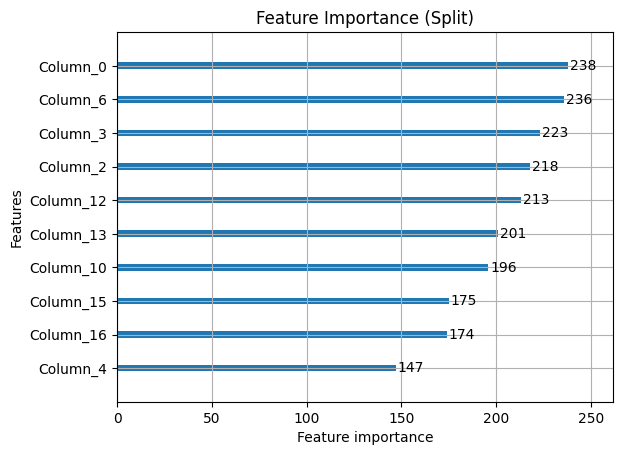

In [37]:
# Importancia 'Split'
predictor = LGBMClassifier(random_state=random_state, **study_lgbm.best_params, verbose=-1, importance_type='split')
optimized_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), predictor)
optimized_pipeline.fit(X_train, y_train)
lgbm.plot_importance(predictor, max_num_features=10, title="Feature Importance (Split)")

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

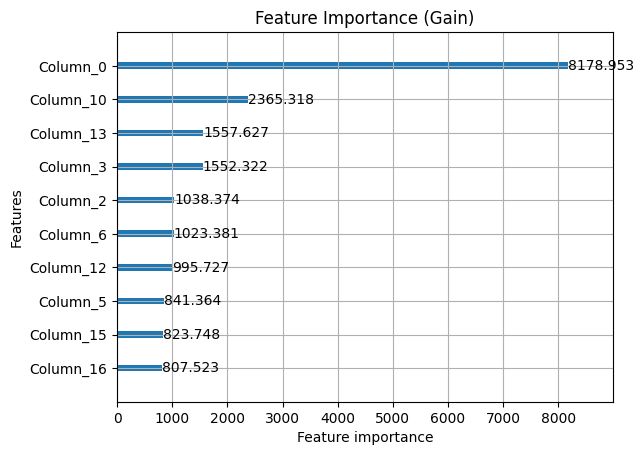

In [35]:
# Importancia 'Gain'
predictor = LGBMClassifier(random_state=random_state, **study_lgbm.best_params, verbose=-1, importance_type='gain')
optimized_pipeline = create_pipeline(generate_scaler(numeric_cols, categorical_cols), predictor)
optimized_pipeline.fit(X_train, y_train)
lgbm.plot_importance(predictor, max_num_features=10, title="Feature Importance (Gain)")

In [23]:
# Se calculan los resultados
result = permutation_importance(optimized_pipeline, X_test, y_test, n_repeats=30, random_state=random_state)
result

{'importances_mean': array([-3.79867047e-04,  2.31085787e-03,  1.89933523e-04, -2.05761317e-03,
         8.00886356e-03, -6.33111744e-05,  7.21747388e-02, -3.19721431e-03,
         6.26464071e-02,  1.19341564e-02,  1.33903134e-02,  1.58277936e-03,
         2.85533397e-02,  5.63469452e-03,  6.48939538e-03, -1.61443495e-03,
         1.99430199e-03, -1.86767965e-03,  3.07059196e-03,  6.33111744e-05]),
 'importances_std': array([0.00274803, 0.00243584, 0.00256469, 0.00316001, 0.00479046,
        0.0025826 , 0.00856107, 0.00242098, 0.00697638, 0.00399676,
        0.00475688, 0.00208543, 0.00855381, 0.00333452, 0.00681331,
        0.00208278, 0.00435434, 0.00373871, 0.0029392 , 0.00023689]),
 'importances': array([[-0.00094967,  0.        ,  0.00189934, -0.00664767,  0.00474834,
          0.00094967, -0.00094967, -0.00189934,  0.00189934, -0.00379867,
          0.        , -0.00094967, -0.002849  , -0.00094967,  0.00664767,
          0.00094967, -0.00094967, -0.002849  , -0.002849  ,  0.0009

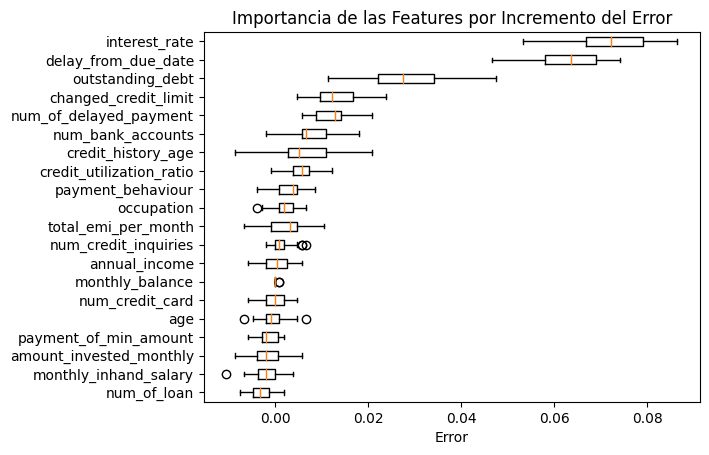

In [39]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

In [25]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [26]:
X_scaler = scaler.fit_transform(X)
X_preprocessed = imputer.fit_transform(X_scaler)

explainer = shap.TreeExplainer(predictor)
shap_values = explainer(X_preprocessed)
shap_values

.values =
array([[[ 5.91349669e-01, -5.91349669e-01],
        [ 1.01261792e-01, -1.01261792e-01],
        [ 4.75246609e-02, -4.75246609e-02],
        ...,
        [-4.22218621e-04,  4.22218621e-04],
        [ 1.71416369e-02, -1.71416369e-02],
        [ 3.83546661e-02, -3.83546661e-02]],

       [[ 5.01056523e-01, -5.01056523e-01],
        [ 1.07477364e-01, -1.07477364e-01],
        [-1.02070792e-01,  1.02070792e-01],
        ...,
        [ 1.13016031e-02, -1.13016031e-02],
        [ 4.46443109e-03, -4.46443109e-03],
        [-1.18213573e-01,  1.18213573e-01]],

       [[ 4.44434979e-01, -4.44434979e-01],
        [ 1.49836825e-01, -1.49836825e-01],
        [ 3.14271134e-01, -3.14271134e-01],
        ...,
        [ 7.56547898e-04, -7.56547898e-04],
        [ 1.78708712e-02, -1.78708712e-02],
        [-7.91966340e-03,  7.91966340e-03]],

       ...,

       [[ 5.14014208e-01, -5.14014208e-01],
        [ 8.38868792e-02, -8.38868792e-02],
        [ 4.42730046e-01, -4.42730046e-01],
        

In [27]:
type(shap_values)

shap._explanation.Explanation

Aporte de las variables para la instancia 1


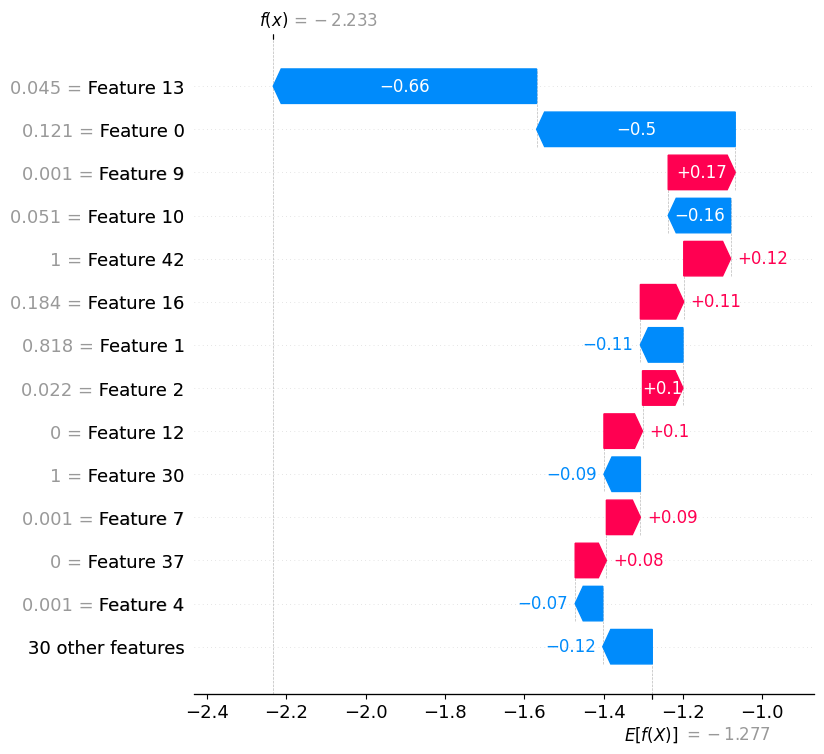

Aporte de las variables para la instancia 9


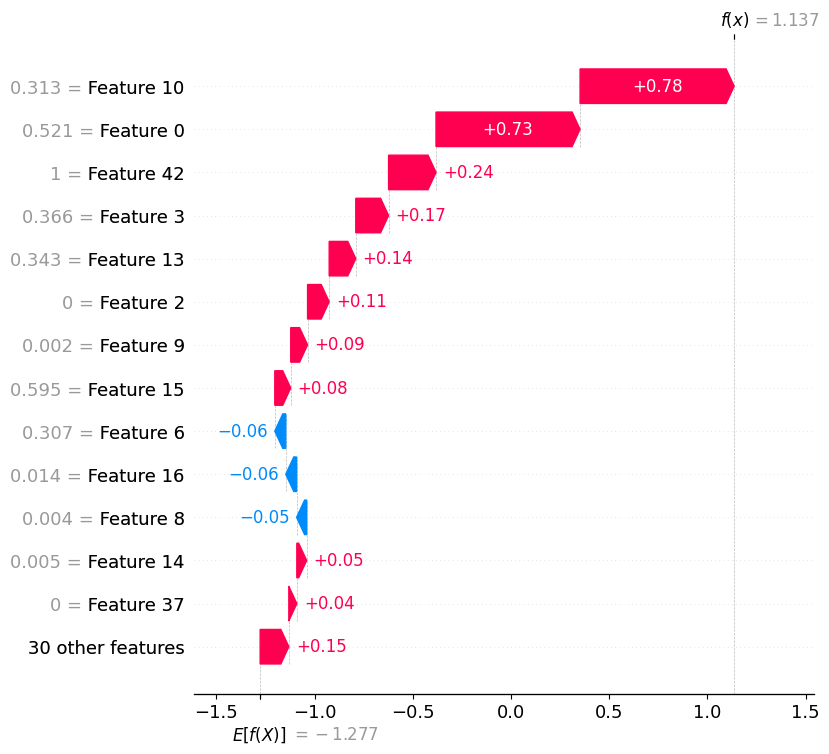

Aporte de las variables para la instancia 50


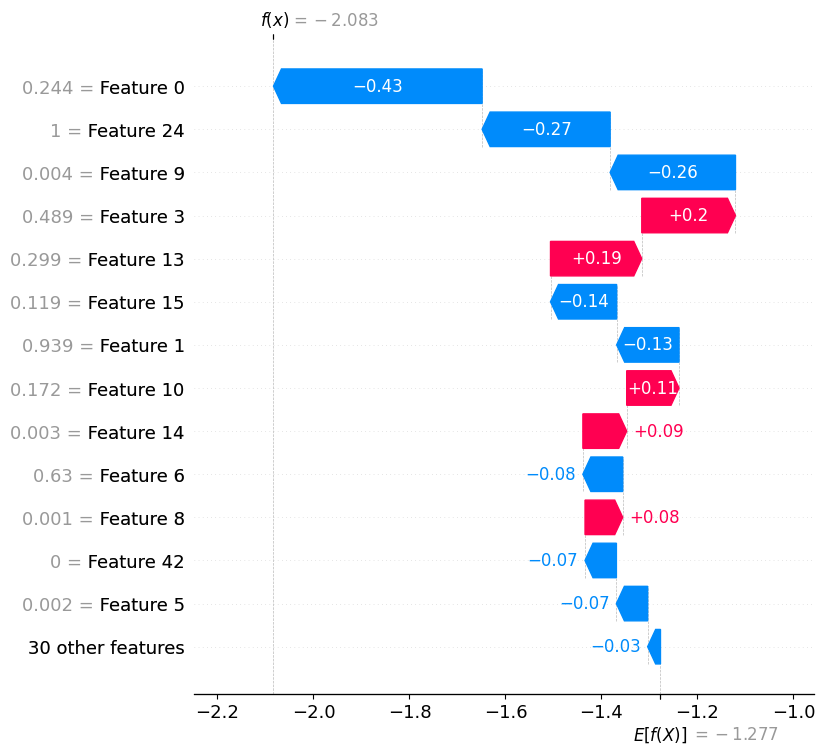

Aporte de las variables para la instancia 150


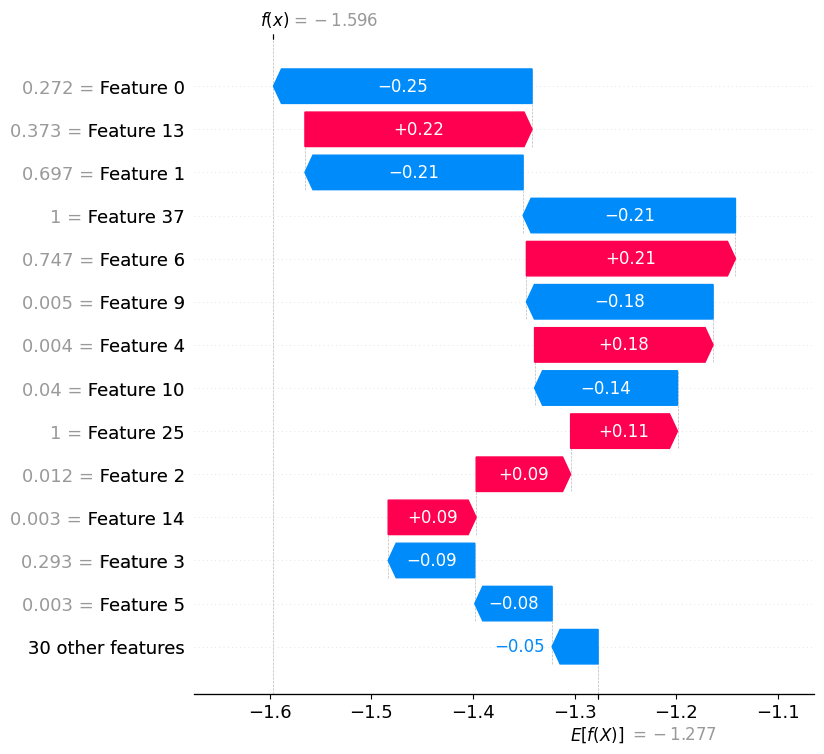

Aporte de las variables para la instancia 1000


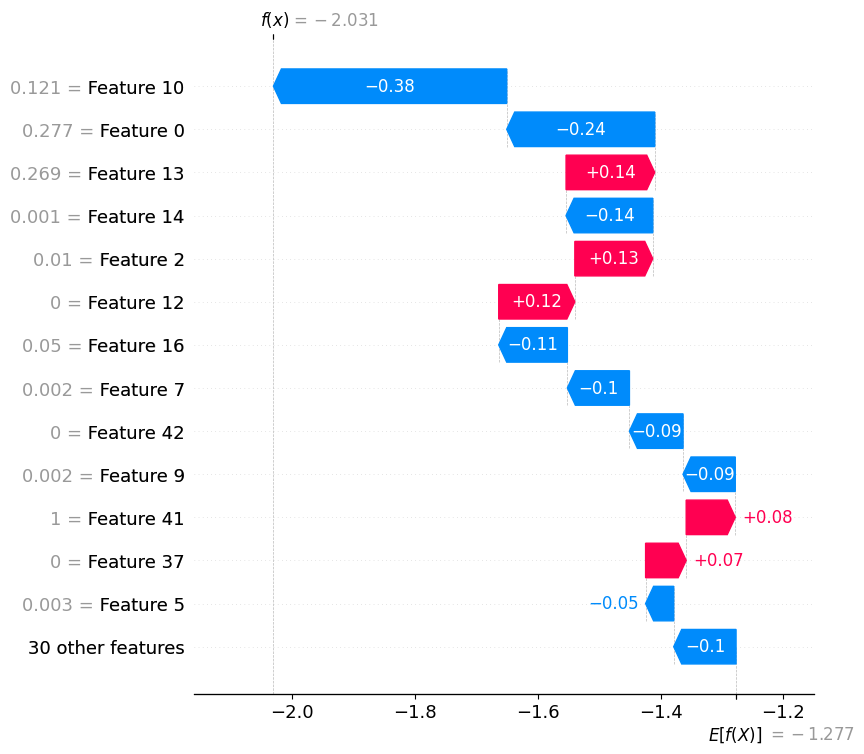

Aporte de las variables para la instancia 2500


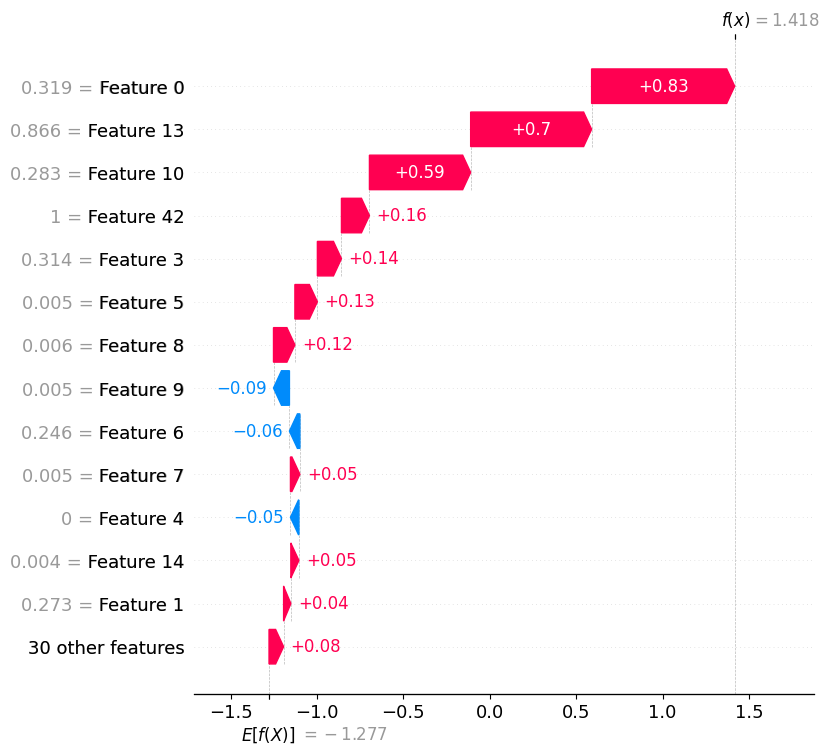

Aporte de las variables para la instancia 4600


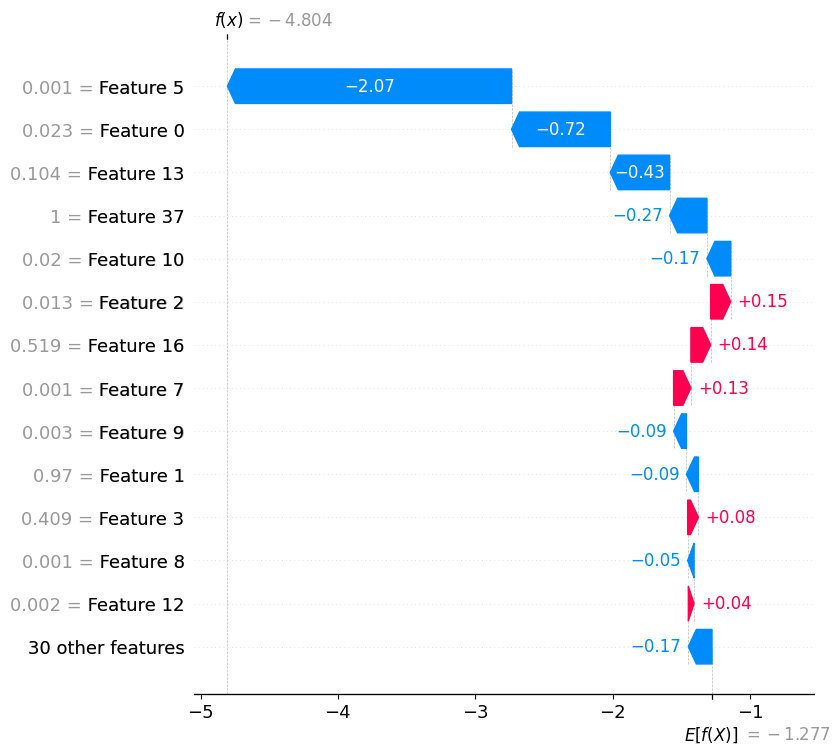

Aporte de las variables para la instancia 6700


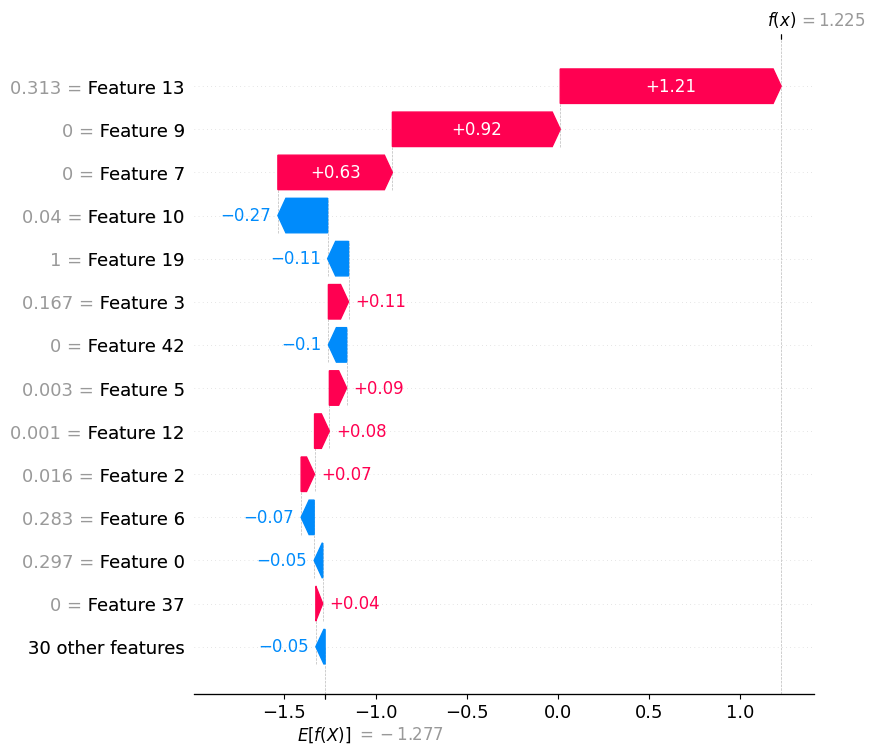

Aporte de las variables para la instancia 7300


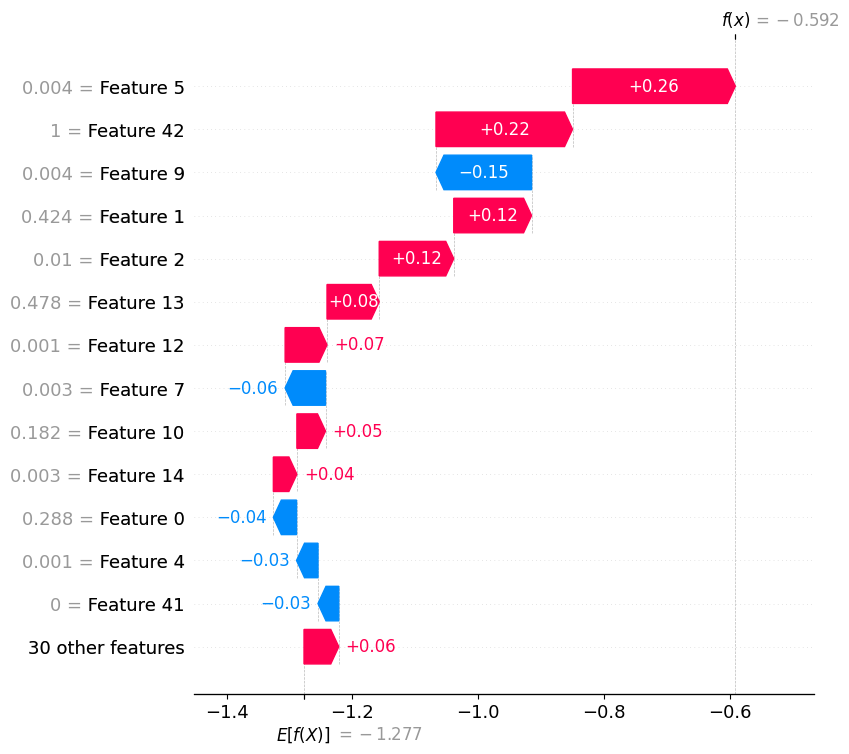

Aporte de las variables para la instancia 9800


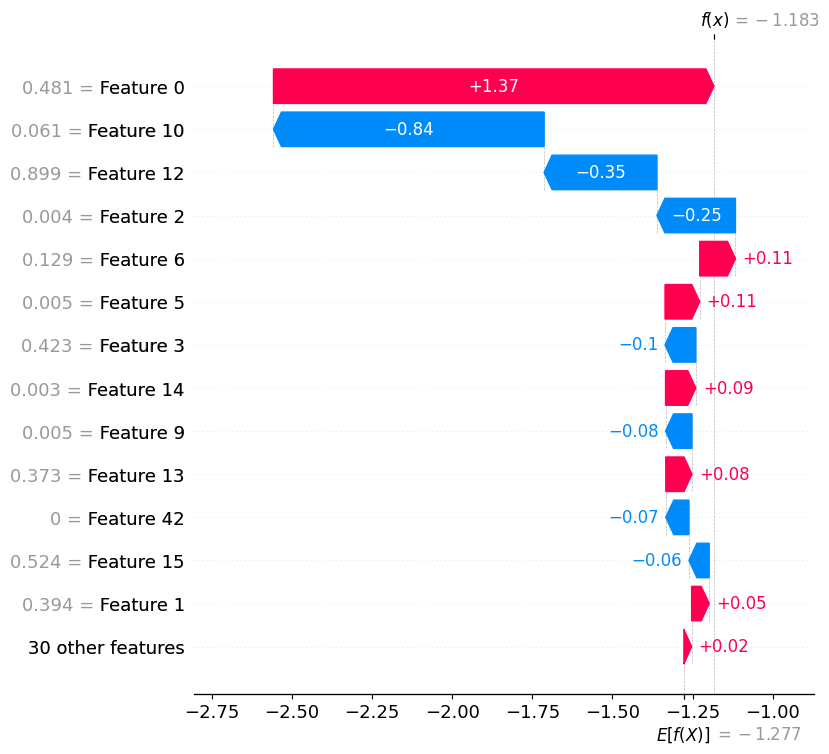

In [40]:
instancias = [1, 9, 50, 150, 1000, 2500, 4600, 6700, 7300, 9800]

for i in instancias:
    print(f"Aporte de las variables para la instancia {i}")
    shap.plots.waterfall(shap_values[i, :, 1], max_display=14)

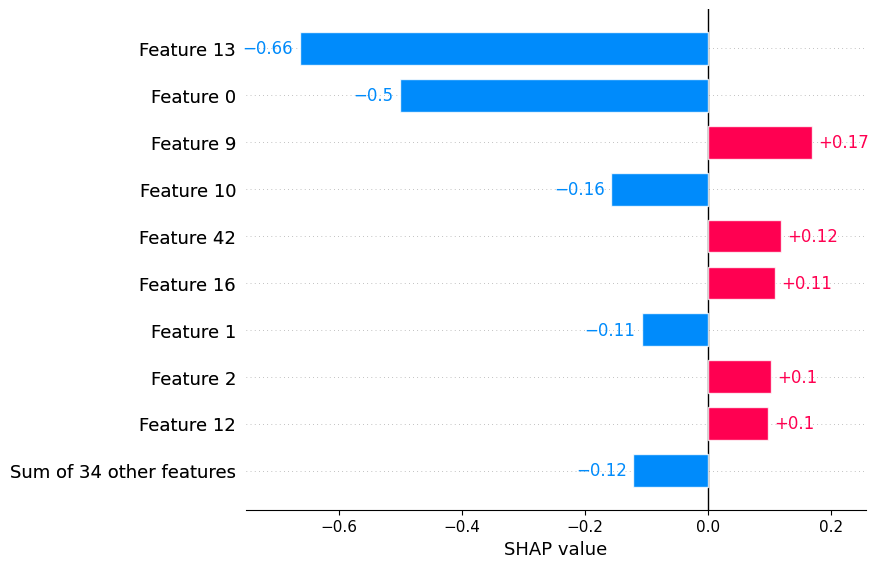

In [29]:
shap.plots.bar(shap_values[1, :, 1])

In [56]:

X_preprocessed.columns[13]

'NumericScaler__delay_from_due_date'

Los resultados obtenidos revelan una distribución de importancia variada entre las diferentes variables evaluadas. De acuerdo con los gráficos de "Feature Importance", la columna 0 resalta como la variable más importante en ambos gráficos generados. Esta coincidencia se justifica debido a que dicha columna representa la deuda pendiente de una persona (`outstanding_debt`), lo cual es bastante lógico. Por otro lado, las columnas 2 y 3 se encuentran dentro de las cinco variables más importantes tanto en el gráfico basado en "split" como en el de "gain". Estas columnas corresponden respectivamente a la cantidad invertida mensualmente (`amount_invested_monthly`) y al cambio en el límite de crédito (`changed_credit_limit`).

Asimismo, al analizar el gráfico de importancia de las características según el incremento del error, se observa que las características más relevantes son: `interest_rate`, `delay_from_due_date` y `outstanding_debt`. La primera corresponde a la columna 10, mientras que la segunda a la columna 13, posicionándose como el segundo y tercer lugar en importancia respectivamente, según el gráfico de "Feature Importance" generado con el método gain. Por otro lado, `outstanding_debt` se destaca como la característica señalada como más importante según "Feature Importance".

Estos resultados indican una tendencia en la importancia de las características, donde se obtuvieron conclusiones similares mediante distintos métodos. Destacan `interest_rate`, `delay_from_due_date` y `outstanding_debt` como características relevantes para el modelo.

Es importante destacar que la distribución de importancia entre las variables no es uniforme. Se identifican algunas características con una relevancia muy baja, como: `num_of_loan`, `monthly_inhand_salary`, `amount_invested_monthly`, `payment_of_min_amount` y `age`, según el gráfico de importancia basado en el incremento del error. Esto sugiere que estas variables no son significativas para el modelo en comparación con otras características.

Al analizar las observaciones aleatorias mediante el método local, se observa que, si bien las contribuciones de las características varían entre las diferentes instancias e incluso entre valores positivos y negativos, se puede identificar un patrón general. De hecho, se destacan en su contribución las mismas variables que sobresalieron en los métodos globales, tales como `interest_rate`, `delay_from_due_date` y `outstanding_debt`, lo que sugiere coherencia en los resultados obtenidos.

En el contexto del problema, para Giturra podría ser más útil utilizar los métodos locales. Estos métodos permiten explicar las decisiones del modelo a nivel individual, lo cual es valioso al evaluar préstamos, ya que brindan comprensión sobre las predicciones. Combinando estas predicciones con el conocimiento y experiencia en el mercado, Giturra puede ofrecer una atención más personalizada y efectiva al predecir la probabilidad de pago de un cliente.

Se sugiere a Giturra la utilización de ambos métodos, ya que los globales brindan una visión general del modelo, mientras que los locales permiten una atención más personalizada. Integrar ambas perspectivas ofrecería una comprensión completa de las predicciones y proporcionaría una atención más efectiva y precisa a los clientes.

### Conclusiones

El problema quedó resuelto, ya que logramos crear un clasificador de personas que no pagan al banquero que efectivamente predice lo que se busca. Los resultados obtenidos no son perfectos, ya que el modelo deja afuera aproximadamente la mitad de las personas, pero ya es un gran avance al permitir al banquero eliminar a la mitad de las personas del banco.
**info del EDA**

El rendimiento del baseline del `LGBMClassifier` mejoró de 0.542 a 0.557 luego de optimizarse, es decir en un 2.77%. Si bien se logró optimizar el baseline y mejorar su capacidad de predicción, no es mucho ya que de por sí el clasificador es bastante bueno. Además, el hecho de que los datos estén desbalanceados no permiten una mejora mayor porque directamente no hay más datos para poder entrenarlo mejor.

Honestamente, podríamos haber tenido mejores resultados. Quizás si hubieramos abordado el problema más como "One-Class Classifier" habríamos tenido mucho mejores resultados, ya que solo estaríamos viendo si los nuevos datos están lo suficientemente cerca de la clase que queremos, en lugar de estar separándolos en dos clases, que necesita muchos más datos. Ahí, usando un algoritmo de clustering habría sido una buena opción.

**que aprendimos xd**